In [1]:
%matplotlib inline  

from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

from read_seq_data import parse_reads_file_format7B
from models import EventType

from constants import BARCODE_V7, NUM_BARCODE_V7_TARGETS

"""
A descriptive analysis of data from the first fish.
"""

In [66]:
START_BASE = 120
BARCODE_SPACER_LEN = 27
TARGET_LEN = 23

In [3]:
cell_reads = parse_reads_file_format7B("../../data/fish_7B_UMI_collapsed_reads.txt")

In [11]:
# Process unique insertions
uniq_inserts = set()
uniq_insert_strs = set()
for b in cell_reads.uniq_barcodes:
    for evt in b.uniq_events:
        if evt.event_type == EventType.INSERT:
            if evt.get_str_id() in uniq_insert_strs:
                continue
            else:
                uniq_insert_strs.add(evt.get_str_id())
                uniq_inserts.add(evt)

# Process insertions with target idx
all_insert_target_pos = []
for b in cell_reads.uniq_barcodes:
    all_target_evts = b.events
    for target_i, target_evts in enumerate(all_target_evts):
        for evt in target_evts:
            if evt.event_type == EventType.INSERT:
                all_insert_target_pos.append((target_i, evt))
all_insert_target_pos = np.array(all_insert_target_pos)

In [14]:
"""
Interpretation: There aren't that many insertion locations possible
"""
num_insert_evt = np.sum([str_id.startswith("EventType.INSERT") for str_id in cell_reads.event_str_ids])
print("# unique insertion events:", num_insert_evt)
insert_pos = [ins.start_pos for ins in uniq_inserts]
num_uniq_insert_start = np.unique(insert_pos).size
print("# unique insertion positions:", num_uniq_insert_start)

# unique insertion events: 328
# unique insertion positions: 59


In [22]:
"""
A summary table of the length of unique insertion events

Interpretation: There is actually a wide range of insertion lengths (up to 48 bp!).
Most insertions are short. However some insertion lengths seem to be more favorable.
Even though we only look at unique insertions, there are a large number of
unique insertions that are all length 12, 15, 20, and 23.
"""
insert_len = [ins.event_len for ins in uniq_inserts]
Counter(insert_len)

Counter({1: 63,
         2: 44,
         3: 27,
         4: 32,
         5: 39,
         6: 25,
         7: 13,
         8: 10,
         9: 9,
         10: 4,
         11: 3,
         12: 13,
         13: 8,
         14: 3,
         15: 8,
         16: 1,
         17: 2,
         18: 2,
         20: 6,
         22: 3,
         23: 10,
         29: 1,
         30: 1,
         48: 1})

In [60]:
"""
Where are things inserted for each target, what is the usual position, what is the usual length?
The numbers below are median (min, max)

Interpretation: Looks like insertion location is not always at the cut site. It could be a little left
of the cut site due to simultaneous deletions maybe?
"""
insert_target_summary = [
    {'count': 0, 'locations': [], 'lengths': [], 'uniq_strs': set()} for i in range(NUM_BARCODE_V7_TARGETS)
]
for target_i, evt in all_insert_target_pos:
    if evt.get_str_id() in insert_target_summary[target_i]['uniq_strs']:
        continue
    else:
        insert_target_summary[target_i]['uniq_strs'].add(evt.get_str_id())
        insert_target_summary[target_i]["count"] += 1
        insert_target_summary[target_i]["locations"].append(evt.start_pos)
        insert_target_summary[target_i]["lengths"].append(evt.event_len)

for target_i, target_dict in enumerate(insert_target_summary):
    print("Target", target_i)
    print("  Count:", target_dict['count'])
    locs = target_dict['locations']
    print("  Location:", np.median(locs), "(", np.min(locs), ",", np.max(locs), ")")
    lens = target_dict['lengths']
    print("  Lengths:", np.median(lens), "(", np.min(lens), ",", np.max(lens), ")")

Target 0
  Count: 85
  Location: 140.0 ( 136 , 142 )
  Lengths: 6.0 ( 1 , 23 )
Target 1
  Count: 93
  Location: 166.0 ( 163 , 169 )
  Lengths: 5.0 ( 1 , 48 )
Target 2
  Count: 10
  Location: 192.5 ( 190 , 195 )
  Lengths: 7.0 ( 1 , 22 )
Target 3
  Count: 46
  Location: 220.0 ( 217 , 222 )
  Lengths: 5.0 ( 1 , 18 )
Target 4
  Count: 12
  Location: 247.5 ( 245 , 250 )
  Lengths: 2.5 ( 1 , 9 )
Target 5
  Count: 11
  Location: 273.0 ( 271 , 275 )
  Lengths: 2.0 ( 1 , 10 )
Target 6
  Count: 17
  Location: 301.0 ( 298 , 303 )
  Lengths: 2.0 ( 1 , 12 )
Target 7
  Count: 8
  Location: 329.5 ( 325 , 331 )
  Lengths: 1.0 ( 1 , 5 )
Target 8
  Count: 28
  Location: 355.0 ( 352 , 358 )
  Lengths: 2.5 ( 1 , 8 )
Target 9
  Count: 18
  Location: 382.5 ( 379 , 385 )
  Lengths: 4.0 ( 1 , 10 )


(array([ 371.,    9.,    0.,    0.,    0.,   73.,  110.,    0.,    0.,
           0.,    3.,   12.,    0.,    0.,    0.,    0.,  205.,  172.,
           0.,    0.,    0.,    1.,   22.,    0.,    0.,    0.,    0.,
          34.,    0.,    0.,    0.,    0.,    8.,   17.,    0.,    0.,
           0.,    1.,    7.,   25.,    0.,    0.,    0.,  271.,   14.,
           0.,    0.,    0.,    6.,   32.]),
 array([ 136.  ,  140.98,  145.96,  150.94,  155.92,  160.9 ,  165.88,
         170.86,  175.84,  180.82,  185.8 ,  190.78,  195.76,  200.74,
         205.72,  210.7 ,  215.68,  220.66,  225.64,  230.62,  235.6 ,
         240.58,  245.56,  250.54,  255.52,  260.5 ,  265.48,  270.46,
         275.44,  280.42,  285.4 ,  290.38,  295.36,  300.34,  305.32,
         310.3 ,  315.28,  320.26,  325.24,  330.22,  335.2 ,  340.18,
         345.16,  350.14,  355.12,  360.1 ,  365.08,  370.06,  375.04,
         380.02,  385.  ]),
 <a list of 50 Patch objects>)

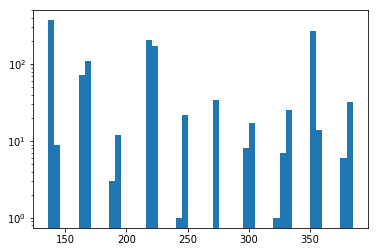

In [17]:
"""
Plot: histogram of insertion positions

Interpretation: Most insertion positions are centered around the cutting locations.
The cut locations are almost equally spaced apart, with some jitter. (This is just a more visual
plot of the list above.)
"""
plt.hist(insert_pos, bins=50, log=True)

In [45]:
"""
Understanding simultaneous deletions and insertions (those that occur in the same position)

Interpretation: There are 10/59 insertion events that overlap with a deletion event on the same barcode.
My guess is that the two happened at the same time.
However I'm a bit surprised that we don't have simultaneous deletion and insertion more often.
"""
simult_del_ins = set()
for b in cell_reads.uniq_barcodes:
    for target_evts in b.events:
        start_idx = 0
        insert_evts = [evt.event_type == EventType.INSERT for evt in target_evts]
        delete_evts = [evt.event_type == EventType.DELETE for evt in target_evts]
        insert_offset_posns = [evt.start_pos + 1 for evt in target_evts if evt.event_type == EventType.INSERT]
        delete_posns = [evt.start_pos for evt in target_evts if evt.event_type == EventType.DELETE]
        num_intersects = (set(insert_offset_posns)).intersection(set(delete_posns))
        if len(num_intersects) == 1:
            del_idx = delete_evts.index(True)
            ins_idx = insert_evts.index(True)
            simult_del_ins.add(target_evts[ins_idx].get_str_id() + "--" + target_evts[del_idx].get_str_id())
print("# simultaneous delete and insert:", len(simult_del_ins))
for del_in in simult_del_ins:
    print(del_in)

# simultaneous delete and insert: 10
EventType.INSERT: 218+18, TTATCATTTTATGTTATT--EventType.DELETE: 219+1
EventType.INSERT: 165+4, TTCT--EventType.DELETE: 166+1
EventType.INSERT: 140+4, GAGG--EventType.DELETE: 141+1
EventType.INSERT: 355+6, GAAGGC--EventType.DELETE: 356+1
EventType.INSERT: 218+6, TCTATT--EventType.DELETE: 219+1
EventType.INSERT: 138+5, AGTAT--EventType.DELETE: 139+2
EventType.INSERT: 167+1, G--EventType.DELETE: 168+3
EventType.INSERT: 271+1, C--EventType.DELETE: 272+11
EventType.INSERT: 273+2, TT--EventType.DELETE: 274+1
EventType.INSERT: 218+2, TT--EventType.DELETE: 219+1


In [17]:
"""
Understanding complex events involving insertions.
Complex events mean there are more than two events in a single target.

Interpretation: There are actually plenty of insertion events without a deletion event.
There are also insertion events with non-overlapping deletion events. I'm not sure why these occur --
is it possible that when we repair the barcode, we actually have a double-strand break in some place and
we patch in a couple of the same bases AND insert some new bases?
There are also double insertions in the same target.
If there are multiple events in the same target, usually the events occur close to each other.
It seems like some of these events actually occurred simultaneously, even though we're processing as separate
events right now.
"""
many_inserts_same_target = set()
inserts_no_dels_same_target = set()
del_ins_no_simul_same_target = set()
for b in cell_reads.uniq_barcodes:
    for target_evts in b.events:
        start_idx = 0
        insert_evts = [evt.event_type == EventType.INSERT for evt in target_evts]
        delete_evts = [evt.event_type == EventType.DELETE for evt in target_evts]
        target_evt_str = "--".join([evt.get_str_id() for evt in target_evts])
        if any(insert_evts) and not any(delete_evts):
            inserts_no_dels_same_target.add(target_evt_str)
        if sum(insert_evts) >= 2:
            many_inserts_same_target.add(target_evt_str)
        if any(insert_evts):
            insert_offset_posns = [evt.start_pos + 1 for evt in target_evts if evt.event_type == EventType.INSERT]
            delete_posns = [evt.start_pos for evt in target_evts if evt.event_type == EventType.DELETE]
            num_intersects = (set(insert_offset_posns)).intersection(set(delete_posns))
            if len(num_intersects) == 0:
                target_evt_str = "--".join([evt.get_str_id() for evt in target_evts])
                del_ins_no_simul_same_target.add(target_evt_str)

print("# insert in a target without any deletions:", len(inserts_no_dels_same_target))
print("# 2+-insertions in a target:", len(many_inserts_same_target))
print("# inserts in a target without overlapping deletions:", len(del_ins_no_simul_same_target))

# insert in a target without any deletions: 259
# 2+-insertions in a target: 40
# inserts in a target without overlapping deletions: 327


In [19]:
# Process unique deletions
uniq_deletes = set()
uniq_delete_strs = set()
for b in cell_reads.uniq_barcodes:
    for evt in b.uniq_events:
        if evt.event_type == EventType.DELETE:
            if evt.get_str_id() in uniq_delete_strs:
                continue
            else:
                uniq_delete_strs.add(evt.get_str_id())
                uniq_deletes.add(evt)

# Process deletions with target idx
all_delete_target_pos = []
for b in cell_reads.uniq_barcodes:
    all_target_evts = b.events
    for target_i, target_evts in enumerate(all_target_evts):
        for evt in target_evts:
            if evt.event_type == EventType.DELETE:
                all_delete_target_pos.append((target_i, evt))
all_delete_target_pos = np.array(all_delete_target_pos)

In [21]:
"""
Counting deletion events and positions

Interpretation: There are quite a lot of deletion positions possible. The total barcode is only 270 long.
We are starting deletes from almost every position.
"""
num_delete_evt = np.sum([str_id.startswith("EventType.DELETE") for str_id in cell_reads.event_str_ids])
print("# unique delete events:", num_delete_evt)
delete_pos = [deletion.start_pos for deletion in uniq_deletes]
num_uniq_delete_start = np.unique(delete_pos).size
print("# unique deletion positions:", num_uniq_delete_start)

# unique delete events: 853
# unique deletion positions: 213


(array([ 366.,  159.,  107.,   57.,   40.,   21.,   15.,   20.,    9.,
           7.,    3.,   12.,   11.,    5.,    6.,    3.,    0.,    2.,
           4.,    6.]),
 array([   1.  ,   12.05,   23.1 ,   34.15,   45.2 ,   56.25,   67.3 ,
          78.35,   89.4 ,  100.45,  111.5 ,  122.55,  133.6 ,  144.65,
         155.7 ,  166.75,  177.8 ,  188.85,  199.9 ,  210.95,  222.  ]),
 <a list of 20 Patch objects>)

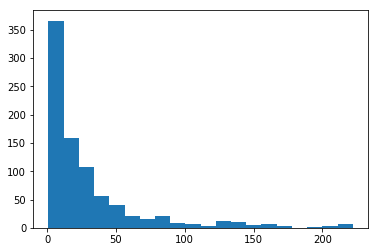

In [83]:
"""
Histogram of the lengths of deletions

Interpretation: Wide range of deletion lengths possible, though more often we delete short lengths.
We even have deletions of 222 bp.
"""
# A summary table of the length of unique deletion events
del_len = [ins.event_len for ins in uniq_deletes]
plt.hist(del_len, bins=20)

(array([  2.,   2.,   4.,  10.,  19.,  24.,  26.,   4.,   1.,   1.,   6.,
          9.,  14.,  16.,  25.,  15.,  26.,  12.,   2.,   1.,   4.,   1.,
          6.,   5.,   6.,  12.,  18.,   7.,   1.,   5.,   4.,   4.,   2.,
         13.,   6.,  15.,  12.,  24.,   5.,   1.,   8.,   4.,   2.,  21.,
          9.,  13.,  29.,  14.,   8.,   4.,   0.,  17.,   4.,  11.,  11.,
          9.,  21.,  13.,  18.,   7.,   3.,   4.,  15.,   5.,   3.,   5.,
         16.,  11.,   0.,   6.,   0.,   2.,   4.,   4.,   8.,   6.,   8.,
         10.,   7.,  10.,   4.,   2.,   5.,  10.,  11.,  21.,   9.,  20.,
         15.,   5.,   1.,   1.,   2.,   2.,   1.,   2.,   2.,   3.,  11.,
          6.]),
 array([ 123.  ,  125.62,  128.24,  130.86,  133.48,  136.1 ,  138.72,
         141.34,  143.96,  146.58,  149.2 ,  151.82,  154.44,  157.06,
         159.68,  162.3 ,  164.92,  167.54,  170.16,  172.78,  175.4 ,
         178.02,  180.64,  183.26,  185.88,  188.5 ,  191.12,  193.74,
         196.36,  198.98,  201.6 ,

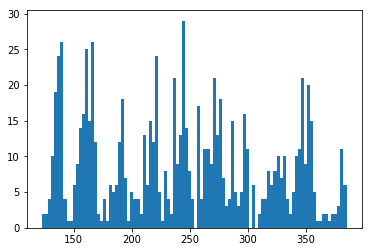

In [46]:
"""
Plot: histogram of deletion start locations

Picture: deletion start locations for each unique deletion event.
You can spot 10 peaks, but it's a bit difficult. Deleions can start anywhere!
"""
plt.hist(delete_pos, bins=100)

In [61]:
"""
Where are things deleted for each target, what is the usual position, what is the usual length?
The numbers below are median (min, max)

Interpretation: The median position for the deletion for each target is pretty evenly spaced.
Median deletion length is actually quite high!
"""
del_target_summary = [
    {'count': 0, 'locations': [], 'lengths': [], 'uniq_strs': set()}
    for i in range(NUM_BARCODE_V7_TARGETS)
]
for target_i, evt in all_delete_target_pos:
    is_target_i_start = evt.start_pos >= START_BASE + BARCODE_SPACER_LEN * target_i
    is_target_i_end = evt.start_pos <= START_BASE + BARCODE_SPACER_LEN * (target_i + 1)
    if is_target_i_start and is_target_i_end:
        if evt.get_str_id() in del_target_summary[target_i]['uniq_strs']:
            continue
        else:
            del_target_summary[target_i]['uniq_strs'].add(evt.get_str_id())
            del_target_summary[target_i]["count"] += 1
            del_target_summary[target_i]["locations"].append(evt.start_pos)
            del_target_summary[target_i]["lengths"].append(evt.event_len)

for target_i, target_dict in enumerate(del_target_summary):
    print("Target", target_i)
    print("  Count:", target_dict['count'])
    locs = target_dict['locations']
    print("  Location:", np.median(locs), "(", np.min(locs), ",", np.max(locs), ")")
    lens = target_dict['lengths']
    print("  Lengths:", np.median(lens), "(", np.min(lens), ",", np.max(lens), ")")

Target 0
  Count: 91
  Location: 138.0 ( 123 , 142 )
  Lengths: 15.0 ( 1 , 222 )
Target 1
  Count: 121
  Location: 162.0 ( 147 , 169 )
  Lengths: 12.0 ( 1 , 219 )
Target 2
  Count: 60
  Location: 191.0 ( 175 , 196 )
  Lengths: 22.0 ( 1 , 201 )
Target 3
  Count: 82
  Location: 217.0 ( 203 , 223 )
  Lengths: 12.5 ( 1 , 204 )
Target 4
  Count: 107
  Location: 243.0 ( 228 , 250 )
  Lengths: 19.0 ( 1 , 152 )
Target 5
  Count: 104
  Location: 269.5 ( 257 , 277 )
  Lengths: 26.0 ( 1 , 129 )
Target 6
  Count: 63
  Location: 295.0 ( 284 , 304 )
  Lengths: 15.0 ( 1 , 123 )
Target 7
  Count: 58
  Location: 323.5 ( 310 , 331 )
  Lengths: 23.5 ( 1 , 71 )
Target 8
  Count: 98
  Location: 348.5 ( 336 , 358 )
  Lengths: 11.0 ( 1 , 58 )
Target 9
  Count: 29
  Location: 380.0 ( 365 , 385 )
  Lengths: 6.0 ( 1 , 29 )


Target 0
Target 1
Target 2
Target 3
Target 4
Target 5
Target 6
Target 7
Target 8
Target 9


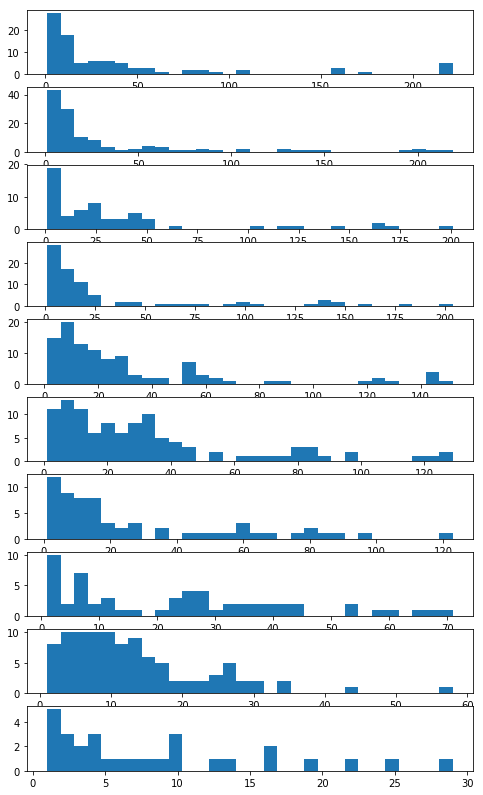

In [62]:
"""
Plot: deletion length histogram for deletion events that start at this target.

Interpretation: The deletion length profiles vary across the targets.
The deletion lengths can vary widely, some going up to 200+ bp.
Shorter deletions are preferred.
"""
plt.figure(figsize=(8,14))
for target_i, target_dict in enumerate(del_target_summary):
    print("Target", target_i)
    plt.subplot(NUM_BARCODE_V7_TARGETS, 1, target_i + 1)
    plt.hist(target_dict['lengths'], bins=30)

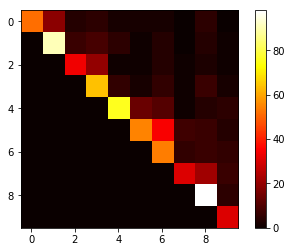

In [95]:
"""
How often do intertarget deletions occur?
e.g. do targets 0 and 9 often get cut together?

Interpretation: most deletions are in the same target. The next most common deletions occur across two targets.
There are very few very long inter-target deletions.
"""
uniq_deletion_strs = set()
intertarget_pairs = np.zeros((NUM_BARCODE_V7_TARGETS, NUM_BARCODE_V7_TARGETS))
for b in cell_reads.uniq_barcodes:
    deletions = dict()
    for target_idx, target_evts in enumerate(b.events):
        for evt in target_evts:
            if evt.event_type == EventType.DELETE:
                evt_id = evt.get_str_id()
                if evt_id in deletions:
                    deletions[evt_id].append(target_idx)
                else:
                    deletions[evt_id] = [target_idx]
    for del_evt, del_targets in deletions.items():
        if del_evt in uniq_deletion_strs:
            continue
        else:
            uniq_deletion_strs.add(del_evt)
            intertarget_pairs[min(del_targets), max(del_targets)] += 1
plt.imshow(intertarget_pairs, cmap='hot')
plt.colorbar()

In [72]:
"""
Understanding double deletions in the same target

Interpretation: There are actually some double deletions within the same target.
I think it was because a longer deletion occurred but some of the same nucleotides
were patched back in so that it may be mis-interpretted as two events instead of
a single one.
"""
many_dels_same_target = set()
many_short_dels_same_target = set()
for b in cell_reads.uniq_barcodes:
    for target_evts in b.events:
        event_lens = [evt.event_len for evt in target_evts if evt.event_type == EventType.DELETE]
        if len(event_lens) >= 2:
            target_evt_str = "--".join([evt.get_str_id() for evt in target_evts])
            many_dels_same_target.add(target_evt_str)
            if np.all(np.array(event_lens) < TARGET_LEN/2):
                many_short_dels_same_target.add(target_evt_str)

print("# 2+-deletions in a target:", len(many_dels_same_target))
print("# 2+-short-deletions (11 bp or less) in a target:", len(many_short_dels_same_target))

# 2+-deletions in a target: 59
# 2+-short-deletions (11 bp or less) in a target: 26


In [82]:
"""
Average number of targets disturbed for each barcode

Interpretation: Most barcodes have most targets modified by the time we sequence.
This is like how the paper mentioned that we have saturated the barcodes.
"""
all_num_disturbed = []
for b in cell_reads.uniq_barcodes:
    num_disturbed = sum([len(target_evts) >= 1 for target_evts in b.events])
    all_num_disturbed.append(num_disturbed)
Counter(all_num_disturbed)

Counter({0: 1,
         2: 3,
         3: 10,
         4: 19,
         5: 34,
         6: 81,
         7: 205,
         8: 431,
         9: 294,
         10: 60})